In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from IPython import display

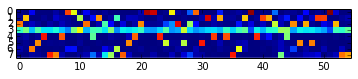

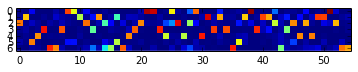

In [2]:
doc_topic = np.genfromtxt('doc_topic.csv',delimiter=',')
topic_word = np.genfromtxt('topic_word.csv',delimiter=',')

with open('vocab.csv') as f:
    vocab = f.read().splitlines()

# Show document distributions across topics
plt.imshow(doc_topic.T,interpolation='none')
plt.show()

# Remove topic 2 = catch all prasa-robmech jargon
doc_topic = np.delete(doc_topic, (3), axis=1)
topic_word = np.delete(topic_word,(3),axis=0)

plt.imshow(doc_topic.T,interpolation='none')
plt.show()

In [3]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
Y = pdist(doc_topic)

D = squareform(Y)

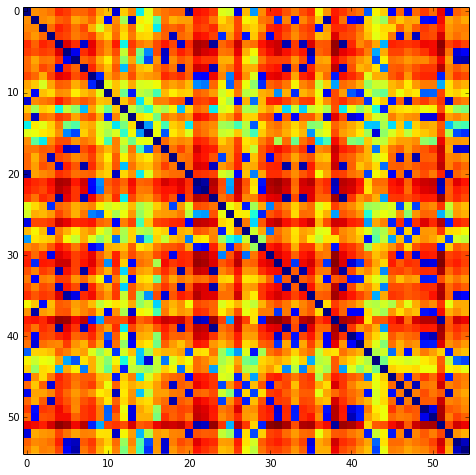

In [4]:
plt.figure(figsize=(15,8))
plt.imshow(D,interpolation='none')
plt.show()

In [5]:
# Number of papers in each session, schedule
session_papers = [5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 3, 3]


In [6]:
def save_schedule():
    
    import xlsxwriter
    from matplotlib import cm
    from matplotlib import colors

    workbook = xlsxwriter.Workbook('example.xlsx')
    worksheet = workbook.add_worksheet()
    worksheet.set_column(0, 0, 10) 
    worksheet.set_column(1, 1, 50)
    worksheet.set_column(2, 4, 80)

    with open('vocab.csv') as f:
        vocab = f.read().splitlines()

    import csv
    paper_details = []
    with open('paper_details.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            paper_details.append(row)

    worksheet.write(0, 0, 'Session')
    worksheet.write(0, 1, 'Topic')
    worksheet.write(0, 2, 'Title')
    worksheet.write(0, 3, 'Authors')
    worksheet.write(0, 4, 'Paper ID')

    cmap = cm.get_cmap('hsv', int(np.max(mfinal)))    # PiYG

    for j,sess in enumerate(sorted(mfinal)):
        i = np.argsort(mfinal)[j]
        detail = paper_details[int(i)]
        Pt = 1.0/session_papers[int(sess)]*np.sum(doc_topic[mfinal==sess,:],axis=0)

        Pw = np.sum(np.multiply(topic_word.T,Pt),axis=1)

        bins = np.argsort(Pw)[-6:]
        sess_topic =  ' '.join(np.array(vocab)[bins].tolist())

        fmt = workbook.add_format()
        fmt.set_border(1)
        fmt.set_bg_color(colors.rgb2hex(cmap(int(sess))[:3]))

        worksheet.write(j+1, 0, sess,fmt)
        worksheet.write(j+1, 1, sess_topic,fmt)
        worksheet.write(j+1, 2, detail['title'],fmt)
        worksheet.write(j+1, 3, detail['authors'],fmt)
        worksheet.write(j+1, 4, detail['paper_id'],fmt)

    workbook.close()

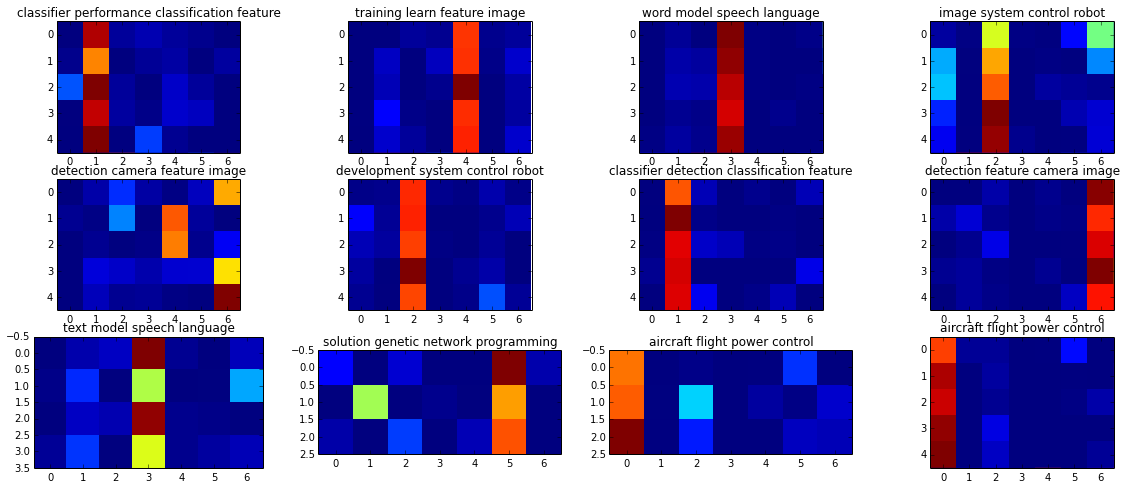

KeyboardInterrupt: 

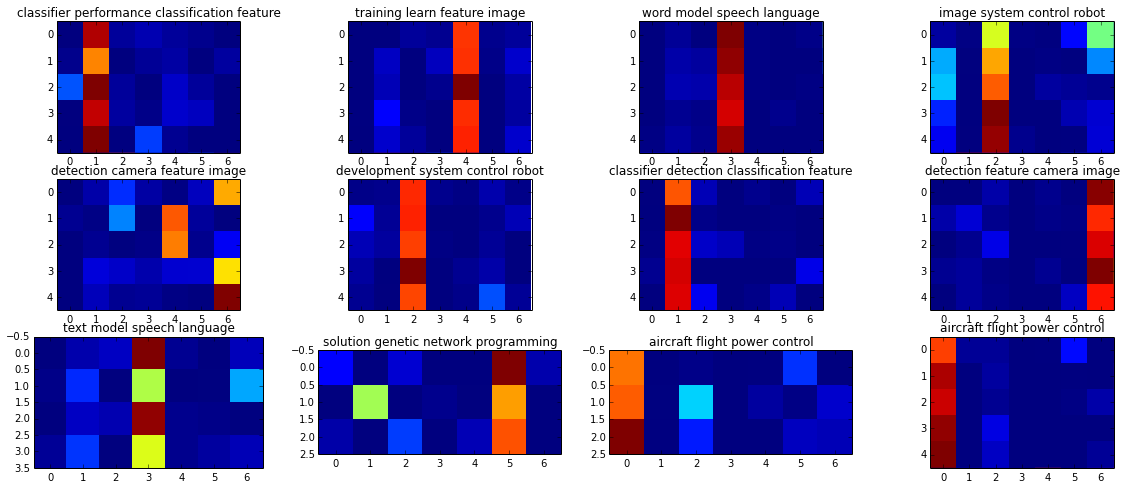

In [7]:
N = doc_topic.shape[0]
K = len(session_papers)

# Greedy clustering
EBest = 10000;

plt.figure(figsize=(20,8))
for reseed_iter in range(10000000):
    
    # Randomly allocate papers to sessions
    mp = np.arange(N)
    np.random.shuffle(mp)
    Gcs = np.hstack((0,np.cumsum(np.array(session_papers))))
    m = np.zeros((N,))
    for j in range(1,Gcs.shape[0]):
        m[(mp<Gcs[j])&(mp >= Gcs[j-1])] = j-1

    # Calculate cost of session assignment
    E = 0
    for k in range(K):
        i,j = np.meshgrid(np.where(m==k),np.where(m==k))
        E = E + np.sum(D[i,j])/(D.shape[0]*D.shape[0])
    E = E/K
    
    t = 0
    while(1):
        E_p = E
        rp = np.arange(N)
        np.random.shuffle(rp)
        for a in rp:
            for b in set(range(N)) - set([a]):
                temp = m[a]
                m[a] = m[b]
                m[b] = temp
                E_t = 0
                for k in range(K):
                    i,j = np.meshgrid(np.where(m==k),np.where(m==k))
                    E_t = E_t + np.sum(D[i,j])/(D.shape[0]*D.shape[0])
                E_t = E_t/K
                if (E_t < E):
                    E = E_t
                    #print "Iter:", reseed_iter, t,a,b,E,EBest
                    #display.clear_output(wait=True)
                else:
                    m[b] = m[a]
                    m[a] = temp
        
        if (E_p == E):
            break
            
        t = t + 1    
    if (E < EBest):
        EBest = E
        mfinal = m
        save_schedule()
        #Show session distribution assignments
        for i in range(K):
            plt.subplot(3,4,i)
            plt.imshow(doc_topic[mfinal==i,:],interpolation='none')
            Pt = 1.0/session_papers[i]*np.sum(doc_topic[mfinal==i,:],axis=0)
            Pw = np.sum(np.multiply(topic_word.T,Pt),axis=1)
            bins = np.argsort(Pw)[-4:]
            sess_topic =  ' '.join(np.array(vocab)[bins].tolist())
            plt.title(sess_topic)
        display.clear_output(wait=True)
        display.display(plt.gcf())
        

In [ ]:
#Show session distribution assignments
plt.figure(figsize=(15,5))
for i in range(K):
    plt.subplot(3,4,i)
    plt.imshow(doc_topic[mfinal==i,:],interpolation='none')
plt.show()

In [ ]:
def save_csv():
    with open('vocab.csv') as f:
        vocab = f.read().splitlines()

    import csv
    paper_details = []
    with open('paper_details.csv') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            paper_details.append(row)

    keys = paper_details[0].keys()
    keys.insert(0,'topic')
    keys.insert(0,'session')

    with open('scheduled_papers.csv', 'wb') as output_file:
        dict_writer = csv.DictWriter(output_file, keys)
        dict_writer.writeheader()
        for j,sess in enumerate(sorted(mfinal)):
            i = np.argsort(mfinal)[j]
            detail = paper_details[int(i)]
            Pt = 1.0/session_papers[int(sess)]*np.sum(doc_topic[mfinal==sess,:],axis=0)
            #Pt = doc_topic[int(i),:]

            Pw = np.sum(np.multiply(topic_word.T,Pt),axis=1)

            bins = np.argsort(Pw)[-6:]
            sess_topic =  ' '.join(np.array(vocab)[bins].tolist())
            print detail['title'][0:40], sess_topic
            detail['topic'] = sess_topic
            detail['session'] = sess
            dict_writer.writerow(detail)